In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch

C:\Users\00050429\Anaconda3\envs\dl_train\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
data_df = pd.read_csv('data\\Training_set.csv')
labels = list(data_df.label.unique())
labels.sort()
class_labels = {}
label_class = {}
for i in range(len(labels)):
    class_labels[labels[i]] = i
    label_class[i] = labels[i]
num_classes = len(labels)

In [32]:
test_df = pd.read_csv('data\\Testing_set.csv')
test_df

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg
...,...
5395,Image_5396.jpg
5396,Image_5397.jpg
5397,Image_5398.jpg
5398,Image_5399.jpg


In [4]:
class TestDataset(Dataset):
    def __init__(self, annotations_csv, img_dir, class_labels,transform=None):
        self.img_labels = annotations_csv
        self.img_dir = img_dir
        self.transform = transform
        self.class_labels = class_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        return image, self.img_labels.iloc[idx, 0]


In [33]:
import torchvision.transforms as T
transform = T.Compose([T.Resize(255), 
       T.CenterCrop(224),  
       T.RandomHorizontalFlip(),
       T.ToTensor(), 
       T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



test_set = TestDataset(test_df, 'data\\test', class_labels, transform=transform)
test_dataloader = DataLoader(test_set, batch_size=256, shuffle=False)

In [34]:
from torchvision.models import resnet18
model = resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=num_classes, bias=True)

In [35]:
device = torch.device('cuda:1')
device 

device(type='cuda', index=1)

In [36]:
PATH = 'models\\best_val_loss.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
model = model.to(device)

In [38]:
import torch
model.eval()

result_predictions = []
result_filenames = []
for images, filenames in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    result_predictions.extend(list(predicted.cpu().numpy()))
    result_filenames.extend(filenames)

In [39]:
result_predictions_labels = []
for i in range(len(result_predictions)):
    result_predictions_labels.append(label_class[result_predictions[i]])

In [40]:
result_df = pd.DataFrame(zip(result_filenames, result_predictions_labels), columns=['filename', 'label'])
result_df.head(10)

,filename,label
0,Image_1.jpg,sleeping
1,Image_2.jpg,eating
2,Image_3.jpg,running
3,Image_4.jpg,eating
4,Image_5.jpg,texting
5,Image_6.jpg,clapping
6,Image_7.jpg,cycling
7,Image_8.jpg,hugging
8,Image_9.jpg,laughing
9,Image_10.jpg,drinking


In [41]:
import random
from PIL import Image
from os.path import join

running


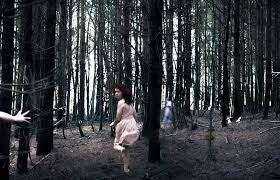

In [42]:
i = random.randint(0,len(result_predictions))
label, filename = result_predictions_labels[i], result_filenames[i]
print(label)
Image.open(fr'data\\test\\{filename}')

In [43]:
result_df.sort_values(by=['filename'])
result_df.to_excel('data\\result.xlsx', index=False)